# Finding "emerging behaviors" in a time series

This notebook reproduces [Matrix Profile XXV: Novelets](https://static1.squarespace.com/static/56dca322f8baf30cf9752a85/t/631900e16f7b7e792701943a/1662583010347/Novelets_V029_CameraReady.pdf). The supporting webpage can be found [here](https://sites.google.com/view/novelets)

This paper proposes an algorithm that can discover emerging behavior, named as **Novelets**, in a time series.

## import libraries

In [47]:
%matplotlib inline

import math
import numpy as np
import matplotlib.pyplot as plt
import stumpy
from stumpy import stump, core, config

from scipy.io import loadmat

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

## Toy data

In [15]:
# Get data from supporting webapge
# link: https://drive.google.com/file/d/1XvZ9mPWiar8YIbxxFDCRPK8wctD0FjcV/view?usp=sharing

data = loadmat('Novelets_datasets/data01_Toy.mat') 
T = np.squeeze(data['pos'])

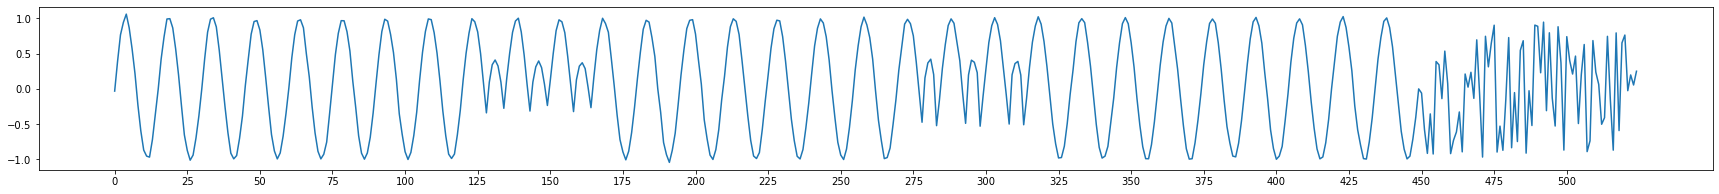

In [16]:
tags = np.arange(0, len(T), 25)

# visualize data
plt.figure(figsize=(30, 3))
plt.plot(T)
plt.xticks(ticks=tags, labels=tags)
plt.show()

Here, we can see that there is a new pattern that is starting around index `125`, and this emerging behavior is repeated at around index `275`. We call the first new subsequence the Novelet. (Note that if we eliminate the second occurance of this behavior, then we cannot call this an emerging behavior! Because, this is basically a unique event, or anomlay)

---

There are few things need to be clarified though (see [paper](https://static1.squarespace.com/static/56dca322f8baf30cf9752a85/t/631900e16f7b7e792701943a/1662583010347/Novelets_V029_CameraReady.pdf) for further details).

**1) Why not motif?** 
While novelets may be time series motifs, most motifs are not Novelets. For example, `Beat` in `BeatzBeatyBeatx` is a strong motif. In the incoming stream, we may have something like this: `BeatwBeatvBeatsPadaqBeatrPatajBeat`. If we look at it closely, we can see there is `Pada`/`Pata` pair, which can be seen as an emerging behavior. This may be overlooked by motif discovery.

**2) Why not anomlay?**
An anomaly is typically a shape that occurs once, whereas a Novelet is the first instance of a repeated shape.

**3) Why not chain?**
For one, a chain must be of at least length three, whereas a Novelet may be detected with just two occurences. For another, we can think of `chain` as a slowly changing behavior; however, novelet is a completely novel behavior.

**4) Why not segementation/change detection?**
In a trivial case where there are two regimes, the outputs of segmentations and novelets may both point out to the start of each regime. However, in practice, segmentation usually works well when the data is highly periodic. However, Novelets only need to see two examples of a new behavior.


**5) Why not clustering?**
They have different purposes. For instance, a novelet can detect when new ryhme schemes begin in a song lyric. However, a clustering process results in grouping all words belonging to a scheme.


**[Personal Opinion] Why not the anomaly twin-freak ???**
For instance, can we use [DAMP](https://www.cs.ucr.edu/~eamonn/DAMP_long_version.pdf) to discover anomaly, and then, if it repeats again, we just call it an emerging behavior (?!)

## Novelet
 a Novelet is the **first** instance- of a new behavior- of a **repeated** shape. Note that we cannot say a subsequnce shows an emerging behavior in its first appearence. Because, that might be just a unique event (or anomaly). If this behavior is repeated again, then we can call it an emerging behavior. 
 
Therefore, if the novelet subsequence `S` appears later as `S'`, then we call `S` novelet. Therefore, to detect novelet, our aim is to find `S'`, a subsequence that has a close left nearest neigbor but is far from the regular patterns in the data. 

We now demonstrate how this concept works. We first need to create `T_ref`, a time series that contains the patterns that cannot be considered as emerging behavior. For instance, in the previous figure, the sinusoidal curve can be considered as the background data. Hence, we would like to avoid choosing a pattern as an emerging behavior if it is similar to sinusoidal curve.

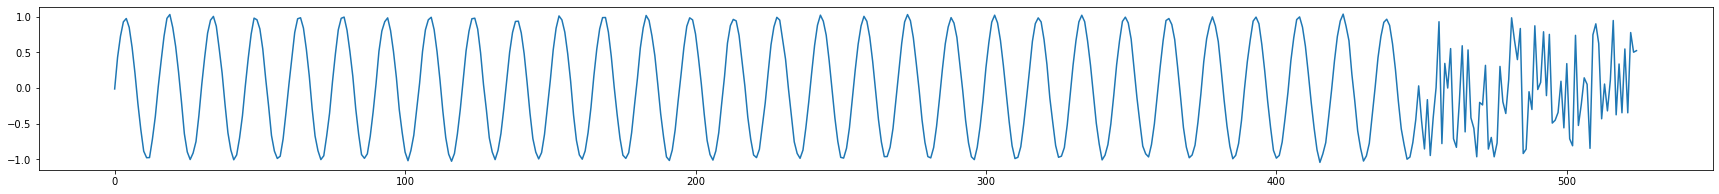

In [17]:
# plot T_ref
T_ref = np.squeeze(data['neg']) 

plt.figure(figsize=(30, 3))
plt.plot(T_ref)
plt.show()

This data contains the sinusoidal curve as well as noise. We can create this data synthetically. In the paper, the authors considered an equal length for sinusoidal curve and noise (see Fig. 3). However, they do not mention why "equal" length. I think it is not important since, as stated in the paper, it is possible to start with an empty `T_ref`.

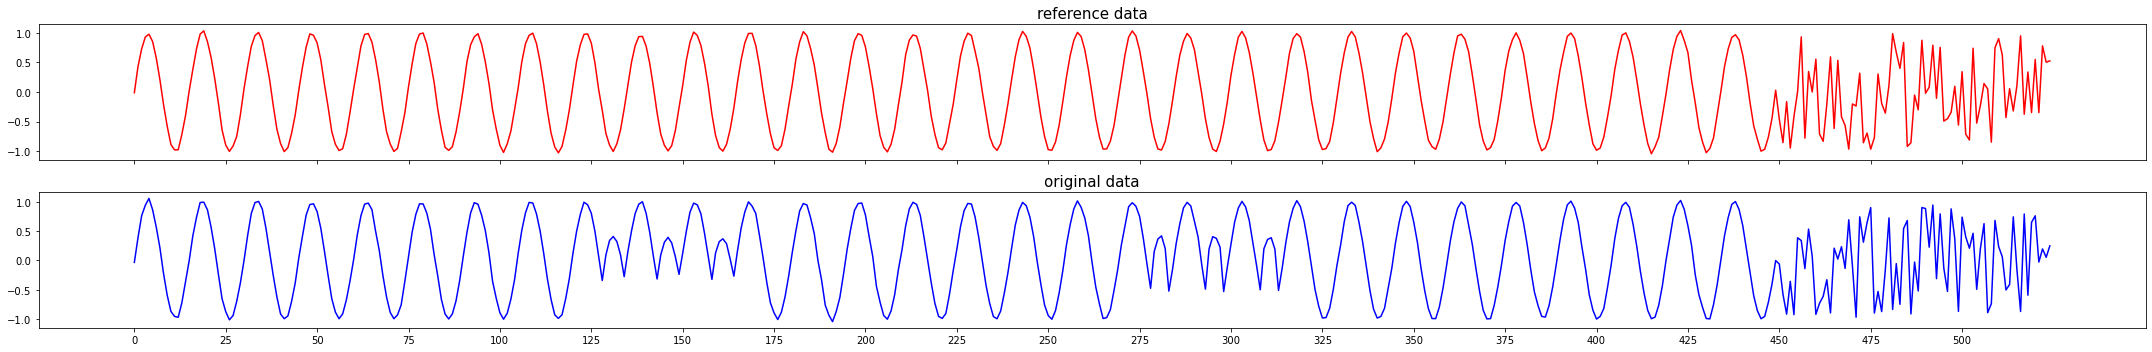

In [28]:
tags = np.arange(0, len(T), 25)

fig, axs = plt.subplots(2, 1, figsize=(30, 5), sharex=True)
axs[0].plot(T_ref, color='r')
axs[0].set_title('reference data', fontsize=15)

axs[1].plot(T, color='b')
axs[1].set_title('original data', fontsize=15)
axs[1].set_xticks(tags)
axs[1].set_xticklabels(tags)
plt.tight_layout()
plt.show()

Recall that the novelet is at index 125. And, this behavior is new compared to the patterns in `T_ref` (top figure).
To find the emerging behavior, we first need to calculate  the "Emergence Profile", `EP`:


$$
\begin{align}
EP ={}& MatrixProfile(T, T\_ref) - LeftMatrixProfile(T)
\end{align}
$$


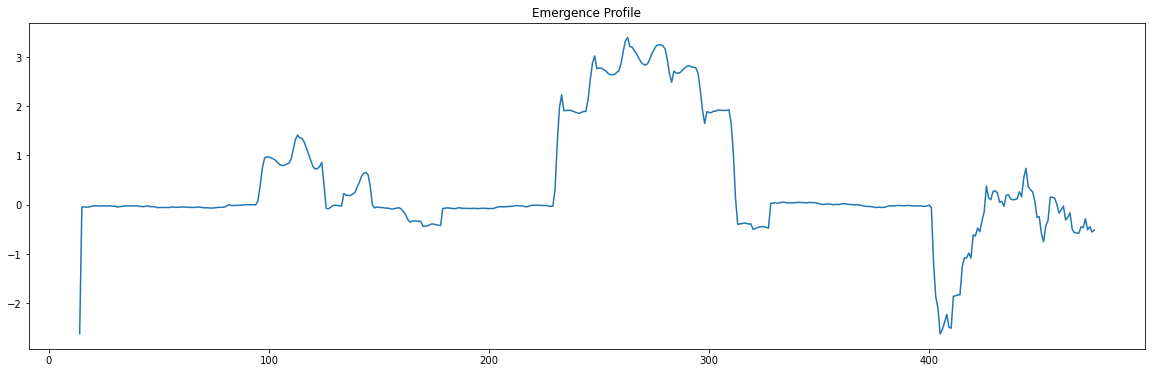

In [29]:
T_A = T.copy()
T_B = T_ref.copy()

m = 50
mp_AB = stumpy.stump(T_A, m, T_B, ignore_trivial=False)
P_AB = mp_AB[:, 0].astype(np.float64)

mp_AA = stumpy.stump(T_A, m)
IL = mp_AA[:, 2].astype(np.int64) # left matrix profile indices
P_AA_left = stumpy.core._idx_to_mp(IL, T_A, m)

EP = P_AB - P_AA_left

# plot EP

plt.plot(EP)
plt.title("Emergence Profile")
plt.show()

In [30]:
idx = np.argmax(ep)
print('index with highest value in EP: ', idx)

index with highest value in EP:  263


Note that a high value at index `idx=263` means that the subsequence starting at this index has large distance to its NN in the reference time series `T_ref`, but it has a small distance to its left nearest neighbor in main data `T`. In other words, this is a new behavior that is not close to the (regular) patterns in reference, but it occured once before in the time series `T`.

Now, we can use the left matrix profile `IL`, to find the first occurance of this behavior:

In [31]:
idx_novelet = IL[idx]
print(f'The Novelet start at index {idx_novelet}')

The Novelet start at index 113


**Finally, let's plot the novelet and its second occurence**

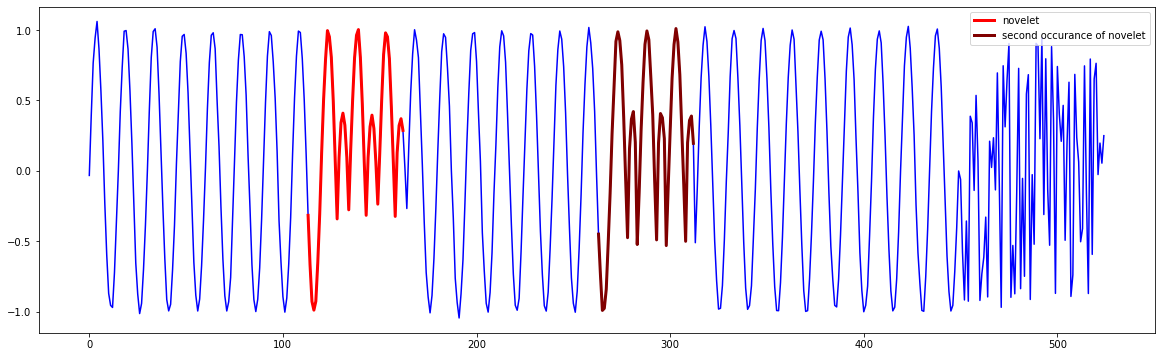

In [34]:
plt.plot(T, color='b')
plt.plot(np.arange(idx_novelet, idx_novelet + m), T[idx_novelet:idx_novelet+m], color='r', linewidth=3, label='novelet')
plt.plot(np.arange(idx, idx + m), T[idx:idx+m], color='maroon', linewidth=3, label='second occurance of novelet')
plt.legend()
plt.show()

## Clipping distances at $\sqrt{2m}$

According to the paper, authors modified mass algorithm and clip distances at $\sqrt{2m}$. As stated by the authors, the reason is that those values correspond to pairs of subsequences that are anti-correlated. This is done to make the greatest use of the normalized range **[Personal opinion: I do not think so! See below]**



The z-normalized Euclidean distance is in range $[0, \sqrt{4m}]$. However, for $\rho < 0$, the distance becomes greater than $\sqrt{2m}$. So, if we clip the distances at $\sqrt{2m}$, as authors said, then all distances will be in $[0, \sqrt{2m}]$, and if we normalize these distances according to the length of subsequence, i.e., dividing by $\sqrt{2m}$, then the distances will be in range `[0, 1]`. So, we can use different length `m`, and choose the one that shows highest value in the emergence profile. So, we can find a better `m`. 

**[Personal Opinion:]** If we divide $\sqrt{4m}$ by $\sqrt{2m}$, the distances will be in range `[0, 2]`. Therefore, we can still use this independent-from-m range to compare emergence profiles of different `m`. I cannot find the need for clipping distances at $\sqrt{2m}$.

## Novelet algorithm
This implemnts Table 1 in the paper. STUMPY's modules are used here. So, there is a slight difference in our implementation as we do not clip distances at $\sqrt{2m}$. To do that, one needs to modify the `stump` function by setting $\rho=0$ whenever $\rho$ becomes negative.

**[Personal Opinion]** I think we need to use **class** instead of function as we just need to update some variables for each new incoming `t`. We need to create `__init__(self, T_A, m, T_B, d)` and `.update(self, t)`. We need to find a way to update T_B properly and set `d` accordingly.]**

In [124]:
class novelets:
    """
    Find the novelets in time series T_A by using T_B as the reference for regular patterns.
    
    Parameters
    ----------
    T_A : numpy.ndarray
        The time series or sequence containing the main data
        
    m : int
        Window size
        
    T_B : numpy.ndarray
        The time series or sequence containing the regular patterns  
    
    d : float
        The minimum threshold to accept a subsequence for novelet discovery
    """
    def __init__(self, T_A, m, T_B, d):
        self._T_A = T_A
        self._T_B = T_B
        self._m = m
        self._d = d
        
        self._novelets = np.empty((0, 2), dtype=np.int64)
        self._excl_zone = int(np.ceil(self._m / config.STUMPY_EXCL_ZONE_DENOM))
        
        mp = stumpy.stump(self._T_A, self._m)
        IL = mp[:, 2].astype(np.int64)
        self._PL_AA = stumpy.core._idx_to_mp(IL, T_A, m)
        
        mp_AB = stumpy.stump(self._T_A, m, self._T_B, ignore_trivial=False)
        self._P_AB = mp_AB[:, 0].astype(np.float64)
        
        self._EP = self._P_AB - self._PL_AA  
        self._EP[:] = self._EP / np.sqrt(2 * m)
        
    def update(self, t):
        """
        `t` is the newly-added value from incoming data. 
        """
        self._T_A = np.append(self._T_A, t)
        
        idx = len(self._T_A) - m + 1 - 1 # start idx of last subseq
        S = self._T_A[idx:] 
    
        D_SA = stumpy.core.mass(S, self._T_A)
        stumpy.core.apply_exclusion_zone(D_SA, idx, self._excl_zone, np.inf)
        candidate_idx = np.argmin(D_SA)
        PL_AA_new = D_SA[candidate_idx] 
        self._PL_AA = np.append(self._PL_AA, PL_AA_new)
        
        D_SB = stumpy.core.mass(S, self._T_B) # try to use updated M_T and Σ_T to reduce computing time
        P_AB_new = np.min(D_SB)
        self._P_AB = np.append(self._P_AB, P_AB_new)
        
        EP_new = (self._P_AB[-1] - self._PL_AA[-1]) / np.sqrt(2 * m)
        self._EP = np.append(self._EP, EP_new) # I think we can move this to the if-block below.
        
        if EP_new >= self._d:
            self._novelets = np.r_[self._novelets, [[candidate_idx, idx]]]
            self._T_B = np.append(self._T_B, self._T_B[candidate_idx : candidate_idx + m])
            
        
    @property
    def novelets_indices(self):
        return self._novelets

**Let's try it out:**

In [125]:
T = np.squeeze(data['pos'])
T_ref = np.squeeze(data['neg'])

T_A = T[:250]
T_B = T_ref.copy()

t_values = T[250:300]

Now, we start to appending a `t` value to T_A, and return the novelets.

In [126]:
m = 50
nov = novelets(T_A, m, T_B, d = 0.2) # d=0.5 corresponds to pearon=0.5

In [127]:
for t in t_values:
    nov.update(t)

array([[ 83, 233],
       [ 95, 245],
       [ 96, 246],
       [ 97, 247],
       [ 98, 248],
       [ 99, 249],
       [100, 250]], dtype=int64)

In [135]:
# filtering
IDX = nov.novelets_indices[:, 0]
pos = np.argmax(nov._EP[IDX])

novel_idx = nov.novelets_indices[pos, 0]
novel_idx_pair = nov.novelets_indices[pos, 1]

print('novel_idx: ', novel_idx)

novel_idx:  99


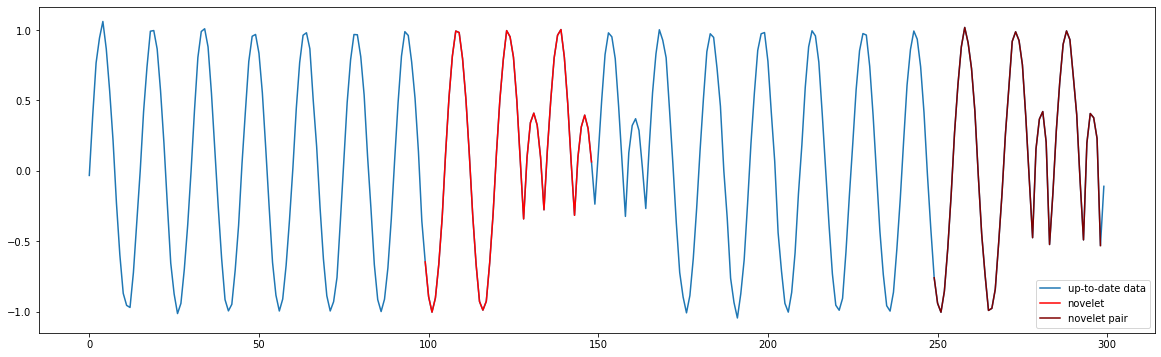

In [134]:
# Let's plot it:
plt.plot(nov._T_A, label='up-to-date data')
plt.plot(
    np.arange(novel_idx, novel_idx + m), nov._T_A[novel_idx : novel_idx + m], color='r', label='novelet'
)

plt.plot(
    np.arange(novel_idx_pair, novel_idx_pair + m), nov._T_A[novel_idx_pair : novel_idx_pair + m], color='maroon', label='novelet pair'
)

plt.legend()
plt.show()